### Init

In [23]:
from dotenv import load_dotenv
from lib.seed import seed_prefix 
import sys, os 
load_dotenv()
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
seed_prefix(seed = 42)

Seed Fix: 42


### [1]-[2]

In [24]:
from lib.dataset import data_split
import pandas as pd 
data_df = pd.read_csv(os.getenv('DATASHEET_PATH'))
data_dir = os.getenv('DATA_DIR')
mask_dir = os.getenv('MEDSAM1_MASK_DIR')
train_df, test_df = data_split(data_df, split_num = 5)
binary_use = False
num_classes = 3

In [35]:
import shutil 
from PIL import Image

benign_dir = '/home/eiden/eiden/otion_project/kohya_ss/dataset/images/ovarian_cyst_data/20_ovarian cyst benigns'
borderline_dir = '/home/eiden/eiden/otion_project/kohya_ss/dataset/images/ovarian_cyst_data/20_ovarian cyst borderlines'
malignant_dir = '/home/eiden/eiden/otion_project/kohya_ss/dataset/images/ovarian_cyst_data/20_ovarian cyst malignants'
for _, row in train_df.iterrows():
    label = 'label|0:양성, 1:중간형, 2:악성'
    if row[label] == 0: # 원래 있던 파일을 복사해서 붙여넣기
        save_dir = benign_dir
        diagnosis_type = 'benign'
    elif row[label] == 1:
        save_dir = borderline_dir
        diagnosis_type = 'borderline'
    elif row[label] == 2:
        save_dir = malignant_dir
        diagnosis_type = 'malignant'
    
    image = Image.open(os.path.join(data_dir, row['filename']+'.png'))
    
    # image = image.resize((1024, 1024))
    
    # crop 80% 비율로 center crop
    width, height = image.size
    new_width = width * 0.8
    new_height = height * 0.8
    left = (width - new_width) / 2
    top = (height - new_height) / 2
    right = (width + new_width) / 2
    bottom = (height + new_height) / 2
    image = image.crop((left, top, right, bottom))
    
    # 사이즈 줄이기
    image.save(os.path.join(save_dir, row['filename']+'.png'))
    # 텍스트를 페어로 저장해주기
    # with open(os.path.join(save_dir, row['filename']+'.txt'), 'w') as f:
    #     f.write(f'An ovarian ultrasound image showing {diagnosis_type} characteristic')
    # print(row['filename'], 'is saved in', save_dir)
    

In [26]:
from lib.dataset import PCOS_Syntheis_Dataset
from torchvision.transforms import v2
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [27]:
import torch 
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


#### [Settings] Train - Hyper Parmas 정의

In [28]:
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch 
import datetime

#### Inference

In [29]:
from lib.dataset import PCOS_Syntheis_Dataset
from torchvision.transforms import v2
from torch.utils.data import DataLoader
test_bs = 9

test_dataset = PCOS_Syntheis_Dataset(
    df = test_df, 
    data_filenames = test_df['filename'],
    data_dir_path  = data_dir,
    mask_dir_path = mask_dir,
    labels         = test_df['label|0:양성, 1:중간형, 2:악성'],
    binary_use = binary_use,
    need_paths = True,
    transform = v2.Compose([
        v2.Resize((296, 296)), # 먼저 296x296으로 Resize
        v2.CenterCrop(252),           # 224x224 중앙 자르기 -> 0.7977
        v2.Grayscale(num_output_channels=1),  # 3채널 회색변환 (RGB 형태 유지)
        v2.ToTensor(),                # 텐서 변환  [0, 255] -> [0.0, 1.0]

    ]),
    mask_transform= v2.Compose([
        v2.Resize((296, 296)), # 먼저 296x296으로 Resize
        v2.CenterCrop(252),           # 224x224 중앙 자르기 -> 0.7977
        v2.ToTensor(),                # 텐서 변환
    ]),
    affine_transform_use = False
)

test_loader = DataLoader(
    test_dataset,
    batch_size = test_bs,
    shuffle = True,
    # sampler= BalancedBatchSampler(
    #     dataset = test_dataset,
    #     labels = test_dataset.labels,
    #     batch_size = test_bs,
    # ),
    pin_memory=True,
    pin_memory_device= "cuda:0",
    persistent_workers=True,
    prefetch_factor = 4,
    num_workers= 8,
)

X1, X1_mask, y, X2, X2_mask, paths = next(iter(test_loader))

import matplotlib.pyplot as plt
try:
    fig, axes = plt.subplots(6, 4, figsize=(12, 18))
    fig.suptitle('PCOS Dataset Augmentation Example', fontsize=16)

    for i in range(6):
        axes[i, 0].imshow(X1[i].cpu().permute(1, 2, 0).numpy(), cmap = 'gray')
        axes[i, 0].set_title(f'X1 - Label: {y[i].item():.0f}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(X1_mask[i].cpu().permute(1, 2, 0).numpy(), cmap = 'gray')
        axes[i, 1].set_title(f'X1_mask - Label: {y[i].item():.0f}')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(X2[i].cpu().permute(1, 2, 0).numpy(), cmap = 'gray')
        axes[i, 2].set_title(f'X2 - Label: {y[i].item():.0f}')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(X2_mask[i].cpu().permute(1, 2, 0).numpy(), cmap = 'gray')
        axes[i, 3].set_title(f'X2_mask - Label: {y[i].item():.0f}')
        axes[i, 3].axis('off')
except Exception as e:
    pass
    print(f"Error during visualization: {e}")

plt.tight_layout()
plt.show()

/home/eiden/miniconda3/envs/pcos/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
# Inference Configs
img_size = 1024  # inference at resolution of 1024 x 1024
img_num = 1335
model_path = 'log/cyclegan_512/s2w_006.pth'
store_dir = 'log/cyclegan_512/s2w_006' 

os.makedirs(store_dir, exist_ok=True)   

# Initialize generators and discriminators
#%% 모델 불러오기
from models import Model_Loader
model = Model_Loader(model_name = 'CycleGAN', num_classes = 1)

Gen = model['G']
model = Gen(input_nc = 1, output_nc = 1).cuda()


Training Time per Epoch:   0%|          | 0/66 [00:00<?, ?it/s]

torch.Size([9, 1, 252, 252])
tensor(-1.0000, device='cuda:0') tensor(1.0000, device='cuda:0')


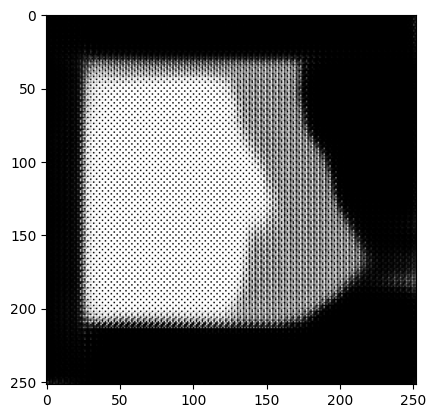

In [ ]:
import cv2
import tqdm

model.load(model_path)
model.eval()

for iteration, (S_imgs, S_masks, labels, W_imgs, W_masks, paths) in tqdm.tqdm(enumerate(test_loader), desc = "Training Time per Epoch", total = len(test_loader)):
    with torch.no_grad():
        # S_imgs, S_masks, W_imgs, W_masks = S_imgs.cuda(), S_masks.cuda(), W_imgs.cuda(), W_masks.cuda()
        # S_inputs = torch.cat([W_imgs, S_masks], dim = 1)
        # faked_W = model(S_inputs)
        S_imgs = S_imgs.cuda()
        faked_W = model(S_imgs)
        print(faked_W.shape)
        print(faked_W[4].min(), faked_W[4].max())
        faked_W = faked_W.cpu().detach().numpy()
        plt.imshow(faked_W[4].squeeze(), cmap = 'gray')
        break 
        # for i in range(len(restored_S)):
        #     restored_S_img = restored_S[i].squeeze()
        #     restored_S_img = (restored_S_img * 255).astype(np.uint8)
        #     cv2.imwrite(f'{store_dir}/{paths[i]}', restored_S_img)

    